In [1]:
# Standard library
import os
import re
import random
import itertools
from itertools import combinations

# Numerical and data analysis
import numpy as np
import pandas as pd

# Statistical analysis
from scipy import stats
from scipy.stats import (
    mannwhitneyu,
    ttest_ind,
    ranksums,
    gaussian_kde)
from statsmodels.stats.multitest import multipletests

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
import seaborn as sns
import ptitprince as pt

# Define paths
plate_map_path = r"L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\plate_map.xlsx"
data_folder = r"L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results"
output_folder = data_folder

In [2]:
# Load the plate map
plate_map = pd.read_excel(plate_map_path, header=None)
plate_map.index = range(len(plate_map))
plate_map.index.name = None
print("Loaded Plate Map:")
print(plate_map)

Loaded Plate Map:
      0                1                2                3                4  \
0  -ATC     0 mismatches     0 mismatches     0 mismatches     0 mismatches   
1  -ATC     2 mismatches     2 mismatches     2 mismatches     2 mismatches   
2  -ATC     9 mismatches     9 mismatches     9 mismatches     9 mismatches   
3  -ATC  scrambled guide  scrambled guide  scrambled guide  scrambled guide   
4  -ATC     0 mismatches     0 mismatches     0 mismatches     0 mismatches   
5  -ATC     2 mismatches     2 mismatches     2 mismatches     2 mismatches   
6  -ATC     9 mismatches     9 mismatches     9 mismatches     9 mismatches   
7  -ATC  scrambled guide  scrambled guide  scrambled guide  scrambled guide   

                 5                6  
0     0 mismatches     0 mismatches  
1     2 mismatches     2 mismatches  
2     9 mismatches     9 mismatches  
3  scrambled guide  scrambled guide  
4     0 mismatches     0 mismatches  
5     2 mismatches     2 mismatches  
6   

In [3]:
# Function to count replicates
def count_replicates(plate_map):
    replicate_counts = plate_map.stack().value_counts()
    return replicate_counts
replicate_counts = count_replicates(plate_map)
print("\nReplicate Counts:")
print(replicate_counts)


Replicate Counts:
0 mismatches       12
2 mismatches       12
9 mismatches       12
scrambled guide    12
-ATC                8
Name: count, dtype: int64


In [4]:
# Define controls *BEFORE* loading and aggregating data
controls = ['-ATC', 'scrambled guide']

In [5]:
# Parse filenames and load data
def parse_filename(filename):

    well_match = re.search(r'Well([A-H]\d{2})', filename)
    z_match = re.search(r'_Z(\d+)', filename)
    if not well_match or not z_match:
        raise ValueError(f"Filename '{filename}' does not match expected format.")
    well = well_match.group(1)
    position = z_match.group(1)
    return well, position


In [6]:
def load_data(data_folder, plate_map):
    data = []
    for file in os.listdir(data_folder):
        if file.endswith(".xlsx") and file != "plate_map.xlsx":
            try:
                well, position = parse_filename(file)
                df = pd.read_excel(os.path.join(data_folder, file))
                df["Well"] = well
                df["Position"] = position
                # Row: 'A' -> 0, 'B' -> 1, etc.
                row_idx = ord(well[0].upper()) - ord('A')
                # Col: '01' -> 0, '12' -> 11, etc.
                col_idx = int(well[1:]) - 1
                if (0 <= row_idx < len(plate_map)) and (0 <= col_idx < len(plate_map.columns)):
                    df["Label"] = plate_map.iloc[row_idx, col_idx]
                else:
                    df["Label"] = np.nan
                data.append(df)
            except Exception as e:
                print(f"Skipping file '{file}' due to error: {e}")
    if data:
        return pd.concat(data, ignore_index=True)
    else:
        return None  # Explicitly return None if no valid data

# --- LOAD DATA ---
data = load_data(data_folder, plate_map)

# --- ONLY PROCEED IF DATA WAS LOADED ---
if data is not None:
    print("Data loaded successfully. Proceeding with analysis.")
    print(data.dtypes)  # Print the data types of the DataFrame
    print(data.head())  # Print the head of the DataFrame
else:
    print("No data loaded. Cannot proceed with analysis.")
    exit()

Data loaded successfully. Proceeding with analysis.
Label              object
Area                int64
Length            float64
Width             float64
Aspect Ratio      float64
Roundness         float64
Mean Intensity    float64
Std Intensity     float64
Centroid X        float64
Centroid Y        float64
Orientation       float64
Well               object
Position           object
dtype: object
  Label  Area     Length      Width  Aspect Ratio  Roundness  Mean Intensity  \
0  -ATC  1046  52.466516  26.055535      2.013642   0.724780      167.845124   
1  -ATC  1001  70.556968  18.507780      3.812287   0.475129      187.134865   
2  -ATC   786  71.517792  15.097277      4.737132   0.407966      178.216285   
3  -ATC   643  35.602413  23.574296      1.510222   0.805056      173.166407   
4  -ATC   355  24.290198  19.518524      1.244469   0.873701      186.923944   

   Std Intensity   Centroid X  Centroid Y  Orientation Well Position  
0      17.564873    53.191205   22.525813   

Data columns: Index(['Label', 'Area', 'Length', 'Width', 'Aspect Ratio', 'Roundness',
       'Mean Intensity', 'Std Intensity', 'Centroid X', 'Centroid Y',
       'Orientation', 'Well', 'Position'],
      dtype='object')

Number of segmented cells per group
             Label  Count
0             -ATC  54215
1     0 mismatches  24795
2     2 mismatches  33159
3     9 mismatches  22762
4  scrambled guide  55272


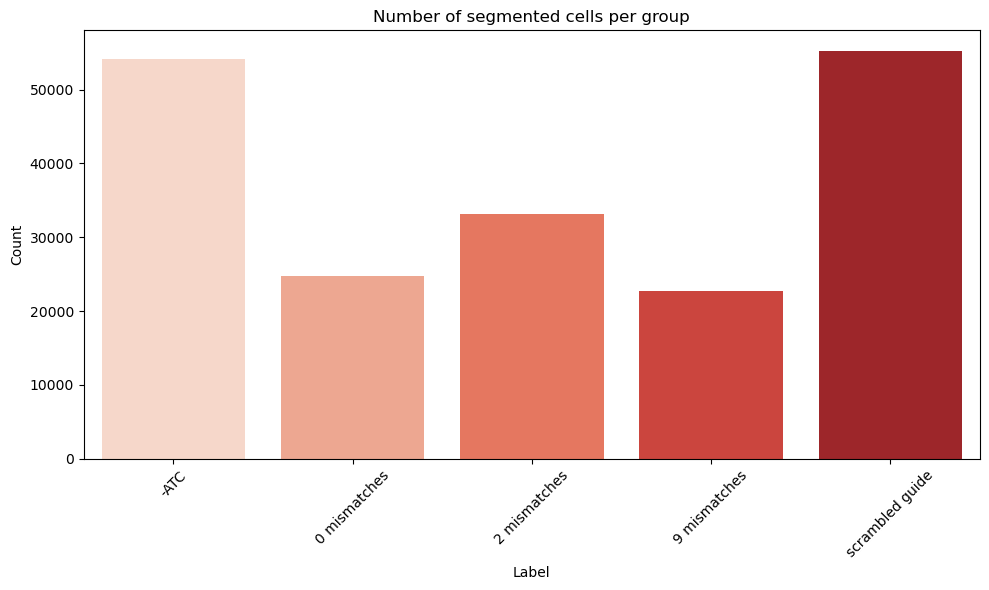

Barplot saved as 'group_counts.svg'.


In [7]:
def aggregate_statistics(data, controls, output_folder):
    print(f"Data columns: {data.columns}")  # Print columns to debug  
    # Convert 'Label' column to string type
    data['Label'] = data['Label'].astype(str) 
    
    # Count datapoints per group (including controls)
    group_counts = data.groupby('Label').size().reset_index(name='Count')
    print("\nNumber of segmented cells per group")
    print(group_counts)

    # Plot the counts as a barplot using the Reds palette
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=group_counts, 
        x='Label', 
        y='Count', 
        palette=sns.color_palette("Reds", n_colors=len(group_counts))
    )
    plt.title('Number of segmented cells per group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('group_counts.svg', format='svg')
    plt.show()
    print("Barplot saved as 'group_counts.svg'.")

    # Exclude controls from groupby for stats
    grouped = data[~data['Label'].isin(controls)].groupby("Label")
    stats = grouped.agg({
        "Area": ["mean", "std"],
        "Roundness": ["mean", "std"],
        "Mean Intensity": ["mean", "std"],
        "Width": ["mean", "std"],
        "Length": ["mean", "std"],
    }).reset_index()

    # Flatten the MultiIndex columns
    stats.columns = [
        "Label", 
        "Area Mean", "Area STD",
        "Roundness Mean", "Roundness STD",
        "Mean Intensity Mean", "Mean Intensity STD",
        "Width Mean", "Width STD",
        "Length Mean", "Length STD",
    ]
    # Append Control stats to stats dataframe
    control_stats = data[data['Label'].isin(controls)].groupby("Label").agg({
        "Area": ["mean", "std"],
        "Roundness": ["mean", "std"],
        "Mean Intensity": ["mean", "std"],
        "Width": ["mean", "std"],
        "Length": ["mean", "std"],
    }).reset_index()
    
    control_stats.columns = [
        "Label", 
        "Area Mean", "Area STD",
        "Roundness Mean", "Roundness STD",
        "Mean Intensity Mean", "Mean Intensity STD",
        "Width Mean", "Width STD",
        "Length Mean", "Length STD",
    ]
    stats = pd.concat([stats, control_stats], ignore_index=True)
    return stats
    os.makedirs(output_folder, exist_ok=True)
    output_file = os.path.join(output_folder, "all_data_points.xlsx")
    output_file_abs = os.path.abspath(output_file)  # Get absolute path
    data.to_excel(output_file_abs, index=False)
    print(f"All individual data points saved to: {output_file_abs}")
    
# Usage example:
try:
    stats = aggregate_statistics(data, controls, output_folder="output_folder")
except Exception as e:
    print(f"Error during aggregation: {e}")
    stats = aggregate_statistics(data, [], output_folder="output_folder")

In [8]:
# Sort the labels in the desired order
def custom_sort(label):
    match = re.match(r'mCh_(\d+)M(\d+)', str(label))  # Ensure label is a string
    if match:
        group = int(match.group(1))
        member = int(match.group(2))
        return (group, member)
    return (float('inf'), float('inf'))

# Apply custom sorting directly and sort
stats['sort_key'] = stats['Label'].apply(custom_sort)
stats = stats.sort_values(by='sort_key')
stats = stats.drop('sort_key', axis=1)  # Remove the temporary column
stats = stats.reset_index(drop=True)

print(stats)

             Label    Area Mean    Area STD  Roundness Mean  Roundness STD  \
0     0 mismatches  1228.769752  482.098999        0.832823       0.690632   
1     2 mismatches  1040.355741  385.131956        0.774996       0.959932   
2     9 mismatches   831.122836  325.024051        0.687152       0.413789   
3             -ATC   919.899585  394.350823        0.696497       0.420490   
4  scrambled guide   814.865176  361.187250        0.667638       0.530667   

   Mean Intensity Mean  Mean Intensity STD  Width Mean  Width STD  \
0           159.977427           37.418829   32.756552   7.518250   
1           164.844282            8.128430   26.035698   5.567993   
2           166.997679            7.659838   21.439144   4.768251   
3           195.286249           14.178199   22.577693   4.963241   
4           203.107803           69.569833   20.371157   4.737094   

   Length Mean  Length STD  
0    47.364444   12.334285  
1    51.098422   15.840368  
2    50.322413   15.717682  


# Plot Comparison #

In [9]:
def plot_comparison(
    stats, 
    data, 
    metric, 
    output_folder, 
    controls=[], 
    quantile_low=0.05, 
    quantile_high=0.95,
    statistics=True,
    y_unit=""  # <-- New parameter for y-axis unit
):
    # Sort stats
    stats = stats.copy()
    stats['sort_key'] = stats['Label'].apply(custom_sort)
    stats = stats.sort_values(by='sort_key').drop(columns='sort_key').reset_index(drop=True)

    # Sample data per group, filter by quantiles
    data = data.copy()
    filtered_data = []
    for label in stats['Label']:
        subset = data[data['Label'] == label]
        if metric in subset.columns and not subset.empty:
            q_low = subset[metric].quantile(quantile_low)
            q_high = subset[metric].quantile(quantile_high)
            filtered = subset[(subset[metric] >= q_low) & (subset[metric] <= q_high)]
            if not filtered.empty:
                filtered_data.append(filtered)
    if not filtered_data:
        print("No data to plot after quantile filtering.")
        return
    plot_data = pd.concat(filtered_data, ignore_index=True)

    # Set style
    sns.set(style="whitegrid", font_scale=1.4)

    # Color palette using 'plasma'
    palette = dict(zip(stats['Label'], sns.color_palette("plasma", len(stats))))

    # Plot setup
    fig_width = min(20, max(10, 0.4 * len(stats)))
    fig, ax = plt.subplots(figsize=(fig_width, 8))
    sns.violinplot(
        x="Label", y=metric, data=plot_data,
        order=stats['Label'], palette=palette,
        cut=2, inner=None, linewidth=1.2, width=1.0, ax=ax
    )

    # Adjust alpha of violin patches
    for artist in ax.findobj(plt.Polygon):
        artist.set_alpha(0.8)

    # Overlay means and connecting lines
    mean_values = stats[f"{metric} Mean"].values
    ax.plot(range(len(stats)), mean_values, color="black", lw=1.5, zorder=2)
    ax.scatter(range(len(stats)), mean_values, color="black", s=60, zorder=3)

    # Axis formatting
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=24)
    y_label = f"{metric} ({y_unit})" if y_unit else metric
    ax.set_ylabel(y_label, fontsize=24)
    ax.set_xlabel("")

    # --- Statistics Section ---
    if statistics:
        group_labels = list(stats['Label'])
        group_data = [plot_data[plot_data['Label'] == label][metric].values for label in group_labels]
        pairs = [(i, i + 1) for i in range(len(group_labels) - 1)]
        p_values = []

        for i, j in pairs:
            try:
                _, p = ranksums(group_data[i], group_data[j])
            except ValueError:
                p = 1.0
            p_values.append(p)

        reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

        max_y = plot_data[metric].max()
        min_y = plot_data[metric].min()
        y_range = max_y - min_y
        annotation_level = [0] * len(group_labels)

        for idx, (i, j) in enumerate(pairs):
            if reject[idx]:
                y_i = plot_data[plot_data['Label'] == group_labels[i]][metric].max()
                y_j = plot_data[plot_data['Label'] == group_labels[j]][metric].max()
                base_y = max(y_i, y_j)
                level = max(annotation_level[i], annotation_level[j]) + 1
                y = base_y + 0.05 * y_range * level
                h = 0.01 * y_range

                ax.plot([i, i, j, j], [y, y + h, y + h, y], lw=1.5, c='k')

                pval = pvals_corrected[idx]
                if pval < 1e-4:
                    stars = '****'
                elif pval < 1e-3:
                    stars = '***'
                elif pval < 1e-2:
                    stars = '**'
                elif pval < 0.05:
                    stars = '*'
                else:
                    stars = 'ns'

                ax.text((i + j) / 2, y + h, stars, ha='center', va='bottom', fontsize=16)

                annotation_level[i] = annotation_level[j] = level

    # Save and show
    plt.tight_layout()
    output_path = os.path.join(output_folder, f"{metric}_comparison_seaborn.svg")
    plt.savefig(output_path, format="svg", bbox_inches="tight")
    print(f"Saved plot: {output_path}")

# Violin Scatter Plot Comparison #

In [10]:
def plot_violin_scatter(stats, data, metric, output_folder, controls=[], max_points_per_group=750, lower_quantile=0.05, upper_quantile=0.95):
    # Sort stats DataFrame based on custom_sort function
    stats = stats.copy()
    stats['sort_key'] = stats['Label'].apply(custom_sort)
    stats = stats.sort_values(by='sort_key').reset_index(drop=True)
    stats = stats.drop('sort_key', axis=1)

    # Prepare data for plotting
    data = data.copy()
    data['GroupType'] = data['Label'].apply(lambda x: 'Control' if x in controls else 'Non-control')

    # Limit points per group and remove outliers using quantiles
    sampled_data = []
    for label in stats['Label']:
        subset = data[data['Label'] == label]
        if metric in subset.columns and not subset.empty:
            # Quantile filtering to remove outliers
            lower = subset[metric].quantile(lower_quantile)
            upper = subset[metric].quantile(upper_quantile)
            subset = subset[(subset[metric] >= lower) & (subset[metric] <= upper)]
            # Limit points per group
            if len(subset) > max_points_per_group:
                subset = subset.sample(max_points_per_group, random_state=42)
            sampled_data.append(subset)
    if not sampled_data:
        print("No data to plot after filtering.")
        return
    plot_data = pd.concat(sampled_data, ignore_index=True)

    # Set style
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(12, 8))

    # Color palette
    palette = dict(zip(stats['Label'], sns.color_palette("Reds", len(stats))))

    # Calculate jitter width based on density for each group
    jitter_x = []
    for label in stats['Label']:
        subset = plot_data[plot_data['Label'] == label]
        if len(subset) > 1:
            fig, ax = plt.subplots()
            sns.kdeplot(subset[metric], bw_adjust=0.5, fill=False, ax=ax)
            line = ax.lines[0]
            x_kde, y_kde = line.get_data()
            plt.close(fig)
            max_width = 0.3
            ykdemax = y_kde.max()
            if ykdemax < 1e-12:  # Avoid division by zero or near-zero
                density_norm = np.full_like(y_kde, max_width * 0.1)
            else:
                density_norm = y_kde / ykdemax * max_width
            jitter_vals = np.interp(subset[metric], x_kde, density_norm)
            # Replace NaN or inf with zero
            jitter_vals = np.nan_to_num(jitter_vals, nan=0.0, posinf=0.0, neginf=0.0)
            jitter_x.extend(jitter_vals)
        else:
            jitter_x.extend([0] * len(subset))

    # Create x positions with density-proportional jitter
    x_positions = []
    jitter_idx = 0
    for i, label in enumerate(stats['Label']):
        count = len(plot_data[plot_data['Label'] == label])
        group_jitter = jitter_x[jitter_idx:jitter_idx+count]
        group_jitter = np.array(group_jitter)
        # Ensure no negative or absurdly large jitters
        group_jitter = np.clip(group_jitter, 0, 0.5)
        x_vals = i + np.random.uniform(-group_jitter, group_jitter)
        x_positions.extend(x_vals)
        jitter_idx += count

    # Plot scatter with jittered positions
    ax = plt.gca()
    pos_idx = 0
    for i, label in enumerate(stats['Label']):
        subset = plot_data[plot_data['Label'] == label]
        n = len(subset)
        x_vals = x_positions[pos_idx:pos_idx + n]
        pos_idx += n
        ax.scatter(x_vals, subset[metric], color=palette[label],edgecolor='black', s=100, label=label, alpha=0.7)

    # Overlay group means and connecting lines
    means = stats[f"{metric} Mean"]
    ax.scatter(range(len(stats['Label'])), means, color="black", s=60,
               label="Group Mean", zorder=3)
    ax.plot(range(len(stats['Label'])), means, color="black", lw=1.5, zorder=2)
    ax.set_xlabel("")  # Remove default x-axis labell

    # Configure axes and save
    plt.xticks(range(len(stats['Label'])), stats['Label'],
               rotation=45, ha="right", fontsize=24)
    plt.ylabel(metric, fontsize=24)
    plt.xlabel("Label", fontsize=24)
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
    plt.tight_layout()
    plt.legend(loc='upper right', frameon=True, fontsize=18)

    output_path = os.path.join(output_folder, f"{metric}_scatter.svg")
    plt.savefig(output_path, format="svg")
    print(f"Saved plot: {output_path}")
    plt.show()

## KDE ##

In [11]:
def plot_mean_intensity_vs_cell_width(stats, data, output_folder, jitter_strength=0.2):
    q_low_intensity = data["Mean Intensity"].quantile(0.01)
    q_high_intensity = data["Mean Intensity"].quantile(0.99)
    q_low_width = data["Width"].quantile(0.01)
    q_high_width = data["Width"].quantile(0.99)

    filtered_data = data[
        (data["Mean Intensity"] >= q_low_intensity) & (data["Mean Intensity"] <= q_high_intensity) &
        (data["Width"] >= q_low_width) & (data["Width"] <= q_high_width)
    ]

    intensity_range = q_high_intensity - q_low_intensity
    width_range = q_high_width - q_low_width
    x_min = q_low_intensity - 0.1 * intensity_range
    x_max = q_high_intensity + 0.1 * intensity_range
    y_min = q_low_width - 0.1 * width_range
    y_max = q_high_width + 0.1 * width_range

    plt.figure(figsize=(14, 8))

    # Use vibrant 'plasma' color palette
    labels = stats["Label"].unique()
    palette = sns.color_palette("plasma", len(labels))

    legend_patches = []

    # KDE plot per group
    for label, color in zip(labels, palette):
        subset = filtered_data[filtered_data["Label"] == label]
        if "Mean Intensity" in subset.columns and "Width" in subset.columns:
            sns.kdeplot(
                x=subset["Mean Intensity"], 
                y=subset["Width"], 
                color=color, 
                fill=True, 
                levels=10, 
                alpha=0.6
            )
            legend_patches.append(Patch(facecolor=color, edgecolor='none', label=label))

    # Mean and STD error bars
    plt.errorbar(
        stats["Mean Intensity Mean"], 
        stats["Width Mean"], 
        xerr=stats["Mean Intensity STD"], 
        yerr=stats["Width STD"],
        fmt='o', color="black", ecolor="black", capsize=5, 
        label="Mean ± STD", markersize=5)
    legend_patches.append(Patch(facecolor='black', edgecolor='none', label='Mean ± STD'))

    # Finalize appearance
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("Mean Intensity", fontsize=24)
    plt.ylabel("Width in px", fontsize=24)
    plt.xlim(q_low_intensity, q_high_intensity)
    plt.ylim(0, q_high_width)
    plt.legend(handles=legend_patches, loc='upper right', fontsize=12, frameon=True)
    plt.tight_layout()

    output_path = os.path.join(output_folder, "Mean_Intensity_vs_Width_KDE_filtered.svg")
    plt.savefig(output_path, format="svg")
    print(f"Saved plot: {output_path}")

In [12]:
def plot_mean_intensity_vs_roundness(stats, data, output_folder, jitter_strength=0.2):
    # Filter to remove outliers using quantiles
    q_low_intensity = data["Mean Intensity"].quantile(0.01)
    q_high_intensity = data["Mean Intensity"].quantile(0.99)
    q_low_roundness = data["Roundness"].quantile(0.01)
    q_high_roundness = data["Roundness"].quantile(0.99)

    filtered_data = data[
        (data["Mean Intensity"] >= q_low_intensity) & (data["Mean Intensity"] <= q_high_intensity) &
        (data["Roundness"] >= q_low_roundness) & (data["Roundness"] <= q_high_roundness)
    ]

    plt.figure(figsize=(14, 8))

    # Color palette
    labels = stats["Label"].unique()
    palette = sns.color_palette("plasma", len(labels))
    legend_patches = []

    # Plot KDE and means line per group
    for label, color in zip(labels, palette):
        subset = filtered_data[filtered_data["Label"] == label]
        if "Mean Intensity" in subset.columns and "Roundness" in subset.columns:
            sns.kdeplot(
                x=subset["Mean Intensity"],
                y=subset["Roundness"],
                color=color,
                fill=True,
                levels=10,
                alpha=0.6
            )
            # Calculate means
            mean_intensity = subset["Mean Intensity"].mean()
            mean_roundness = subset["Roundness"].mean()
            # Store for plotting means line
            plt.scatter(mean_intensity, mean_roundness, color=color, s=120, edgecolor='black', zorder=5)
            legend_patches.append(Patch(facecolor=color, edgecolor='none', label=label))

    # Draw line connecting means (sorted by mean intensity)
    means = []
    for label in labels:
        subset = filtered_data[filtered_data["Label"] == label]
        if not subset.empty:
            mean_intensity = subset["Mean Intensity"].mean()
            mean_roundness = subset["Roundness"].mean()
            means.append((mean_intensity, mean_roundness))
    # Sort by mean intensity to avoid zig-zag lines
    means.sort()
    if len(means) > 1:
        plt.plot(
            [m[0] for m in means],
            [m[1] for m in means],
            color='black',
            linewidth=2,
            linestyle='--',
            label='Means line'
        )

    # Labels and formatting
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("Mean Intensity", fontsize=24)
    plt.ylabel("Roundness", fontsize=24)
    plt.xlim(q_low_intensity, q_high_intensity)
    plt.ylim(0.2, 1)
    plt.legend(handles=legend_patches + [Patch(facecolor='black', edgecolor='none', label='Means line')], loc='upper right', fontsize=12, frameon=True)
    plt.tight_layout()

    output_path = os.path.join(output_folder, "Mean_Intensity_vs_Roundness_KDE.svg")
    plt.savefig(output_path, format="svg")
    print(f"Saved plot: {output_path}")

In [13]:
def plot_combined_mean_intensity_vs_cell_width(stats, data, output_folder, jitter_strength=0.2):
    q_low_intensity = data["Mean Intensity"].quantile(0.01)
    q_high_intensity = data["Mean Intensity"].quantile(0.99)
    q_low_width = data["Width"].quantile(0.01)
    q_high_width = data["Width"].quantile(0.99)

    filtered_data = data[
        (data["Mean Intensity"] >= q_low_intensity) & (data["Mean Intensity"] <= q_high_intensity) &
        (data["Width"] >= q_low_width) & (data["Width"] <= q_high_width)
    ]

    intensity_range = q_high_intensity - q_low_intensity
    width_range = q_high_width - q_low_width

    plt.figure(figsize=(14, 8))

    # Single KDE plot over all data
    sns.kdeplot(
        x=filtered_data["Mean Intensity"],
        y=filtered_data["Width"],
        cmap="plasma",
        fill=True,
        levels=20,
        alpha=0.8,
        bw_adjust=0.3
    )

    # Optional: Add mean ± STD error bars (requires aggregated stats)
    if "Mean Intensity Mean" in stats.columns and "Width Mean" in stats.columns:
        plt.errorbar(
            stats["Mean Intensity Mean"],
            stats["Width Mean"],
            xerr=stats["Mean Intensity STD"],
            yerr=stats["Width STD"],
            fmt='o',
            color="black",
            ecolor="black",
            capsize=5,
            label="Mean ± STD",
            markersize=5
        )

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("Mean Intensity", fontsize=24)
    plt.ylabel("Width in px", fontsize=24)
    plt.xlim(q_low_intensity, q_high_intensity)
    plt.ylim(0, q_high_width)
    plt.legend(loc='upper right', fontsize=12, frameon=True)
    plt.tight_layout()

    output_path = os.path.join(output_folder, "Mean_Intensity_vs_Width_KDE_combined.svg")
    plt.savefig(output_path, format="svg")
    print(f"Saved plot: {output_path}")

In [14]:
def plot_combined_mean_intensity_vs_roundness(stats, data, output_folder):
    # Quantile-based outlier filtering
    q_low_intensity = data["Mean Intensity"].quantile(0.01)
    q_high_intensity = data["Mean Intensity"].quantile(0.99)
    q_low_roundness = data["Roundness"].quantile(0.01)
    q_high_roundness = data["Roundness"].quantile(0.99)

    filtered_data = data[
        (data["Mean Intensity"] >= q_low_intensity) & (data["Mean Intensity"] <= q_high_intensity) &
        (data["Roundness"] >= q_low_roundness) & (data["Roundness"] <= q_high_roundness)
    ]

    plt.figure(figsize=(14, 8))

    # Combined KDE plot over all data
    sns.kdeplot(
        x=filtered_data["Mean Intensity"],
        y=filtered_data["Roundness"],
        cmap="plasma",
        fill=True,
        levels=15,
        alpha=0.6
    )

    # Compute means in bins and plot line
    num_bins = 10
    bins = np.linspace(q_low_intensity, q_high_intensity, num_bins+1)
    filtered_data['Intensity_bin'] = np.digitize(filtered_data["Mean Intensity"], bins)
    bin_means = filtered_data.groupby('Intensity_bin').agg({
        "Mean Intensity": "mean",
        "Roundness": "mean"
    }).dropna()
    plt.plot(
        bin_means["Mean Intensity"],
        bin_means["Roundness"],
        color="black",
        linewidth=2,
        linestyle="--",
        label="Means line"
    )
    plt.scatter(
        bin_means["Mean Intensity"],
        bin_means["Roundness"],
        color="black",
        s=80,
        edgecolor='white',
        zorder=5
    )

    # Plot formatting
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("Mean Intensity", fontsize=24)
    plt.ylabel("Roundness", fontsize=24)
    plt.xlim(q_low_intensity, q_high_intensity)
    plt.ylim(0.2, 1)
    plt.legend(loc='upper right', fontsize=12, frameon=True)
    plt.tight_layout()

    output_path = os.path.join(output_folder, "Mean_Intensity_vs_Roundness_KDE_combined.svg")
    plt.savefig(output_path, format="svg")
    print(f"Saved plot: {output_path}")

## Histogram ##

In [15]:
def plot_mean_intensity_histogram(data, output_folder, controls=[]):
    q_low_intensity = data["Mean Intensity"].quantile(0.01)
    q_high_intensity = data["Mean Intensity"].quantile(0.99)
    plt.figure(figsize=(10, 6))
    labels = data['Label'].unique()
    
    # Use matplotlib's 'plasma' colormap
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(labels)))
    
    bin_count = 100
    bins = np.linspace(q_low_intensity, q_high_intensity, bin_count)
    for color, label in zip(colors, labels):
        subset = data[
            (data['Label'] == label) &
            (data["Mean Intensity"] >= q_low_intensity) &
            (data["Mean Intensity"] <= q_high_intensity)
        ]['Mean Intensity']
        hist, _ = np.histogram(subset, bins=bins)
        if np.sum(hist) > 0:
            hist_normalized = hist / float(np.max(hist))
        else:
            hist_normalized = hist
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_width = bins[1] - bins[0]
        plt.bar(bin_centers, hist_normalized, width=bin_width, alpha=0.8, label=label, color=color)
        
        # Add outline using KDE
        if len(subset) > 1:  # Ensure enough data for KDE
            kde = gaussian_kde(subset)
            x_vals = np.linspace(q_low_intensity, q_high_intensity, 500)
            y_vals = kde(x_vals)
            if np.max(y_vals) > 0:
                y_vals_normalized = y_vals / np.max(y_vals)
                plt.plot(x_vals, y_vals_normalized, color='black', linewidth=1.2)
    
    plt.xlabel("Mean Intensity", fontsize=24)
    plt.ylabel("Normalized Frequency", fontsize=24)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')
    
    # Customize x-ticks
    min_val = q_low_intensity
    max_val = q_high_intensity
    range_vals = max_val - min_val
    step = 10 ** np.floor(np.log10(range_vals / 7))  # Aim for roughly 7 ticks
    start = min_val - min_val % step
    ticks = np.arange(start, max_val + step, step)
    ticks = ticks[(ticks >= min_val) & (ticks <= max_val)]
    plt.xticks(ticks, rotation=45, ha="right")
    
    plt.tight_layout()
    output_path = os.path.join(output_folder, "Mean_Intensity_Histogram.svg")
    plt.savefig(output_path)
    print(f"Saved plot: {output_path}")

# Main #

Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Roundness_comparison_seaborn.svg
Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Mean Intensity_comparison_seaborn.svg
Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Roundness_scatter.svg


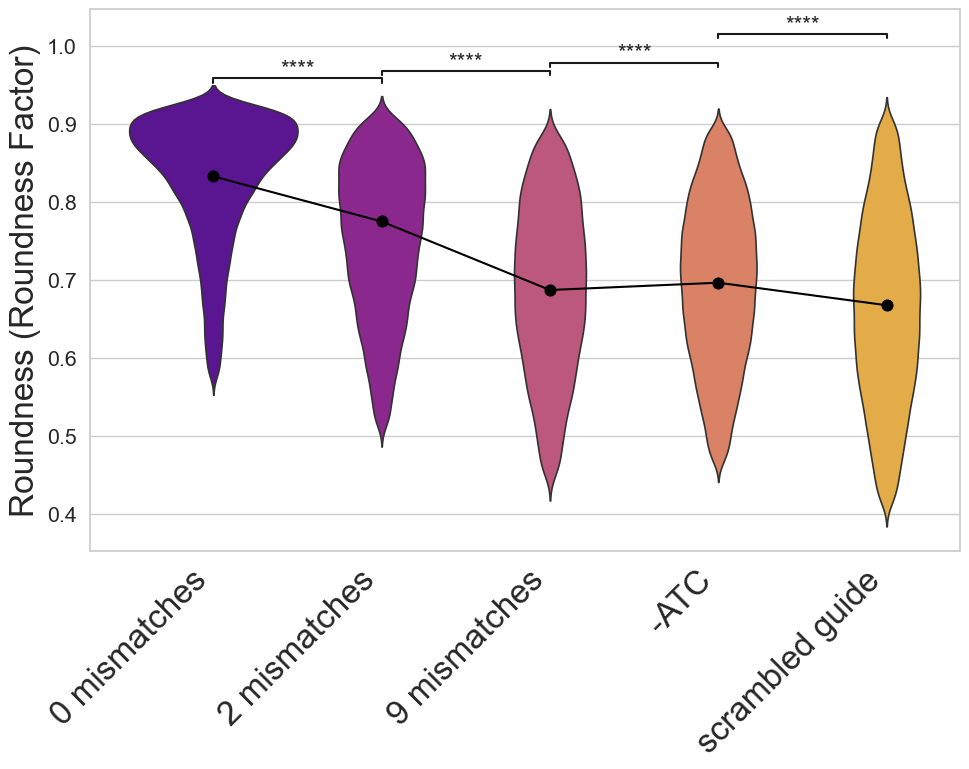

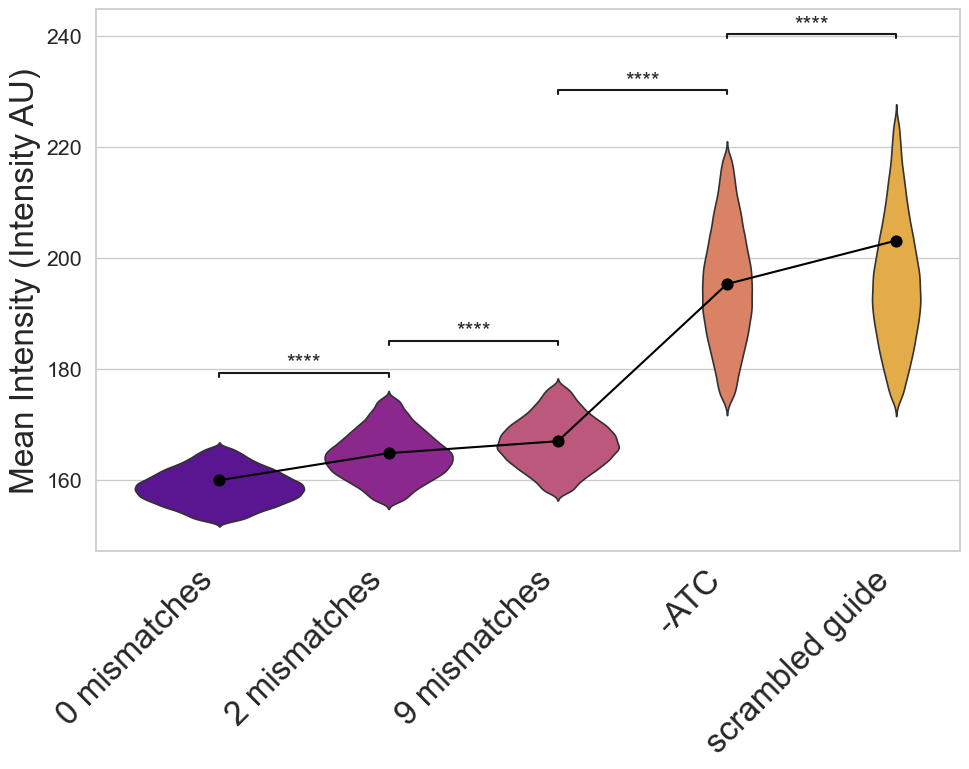

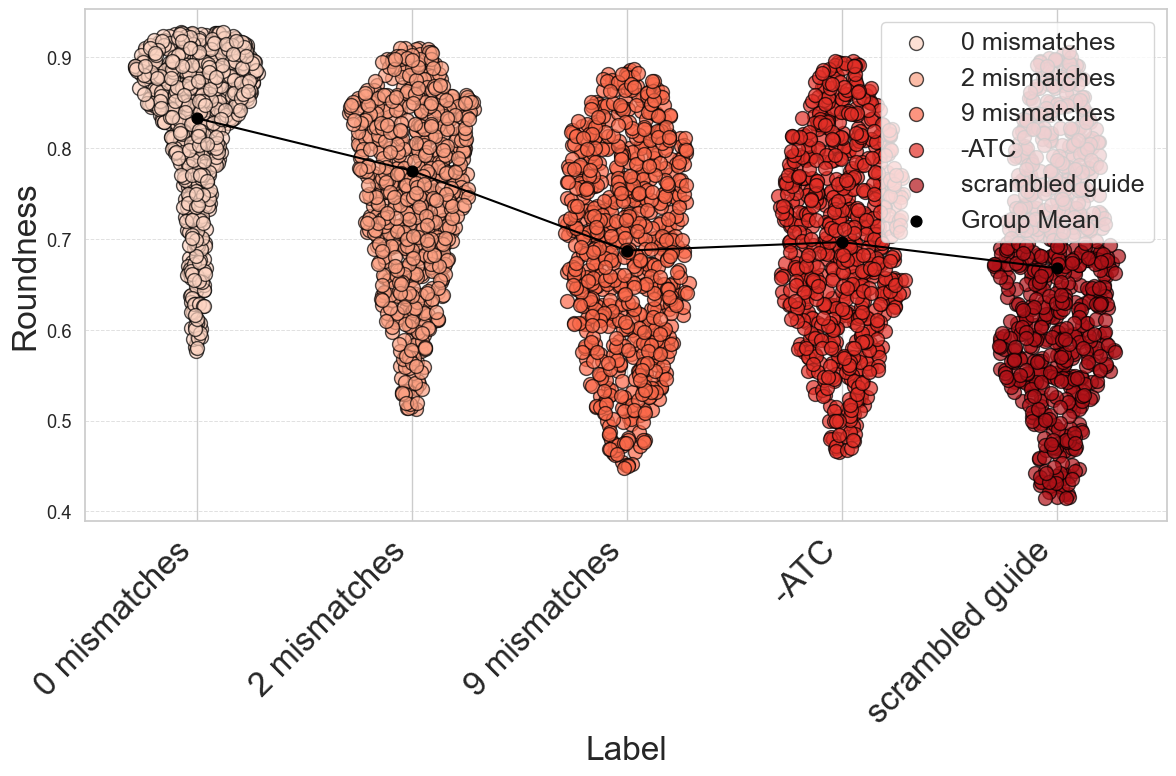

Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Mean Intensity_scatter.svg


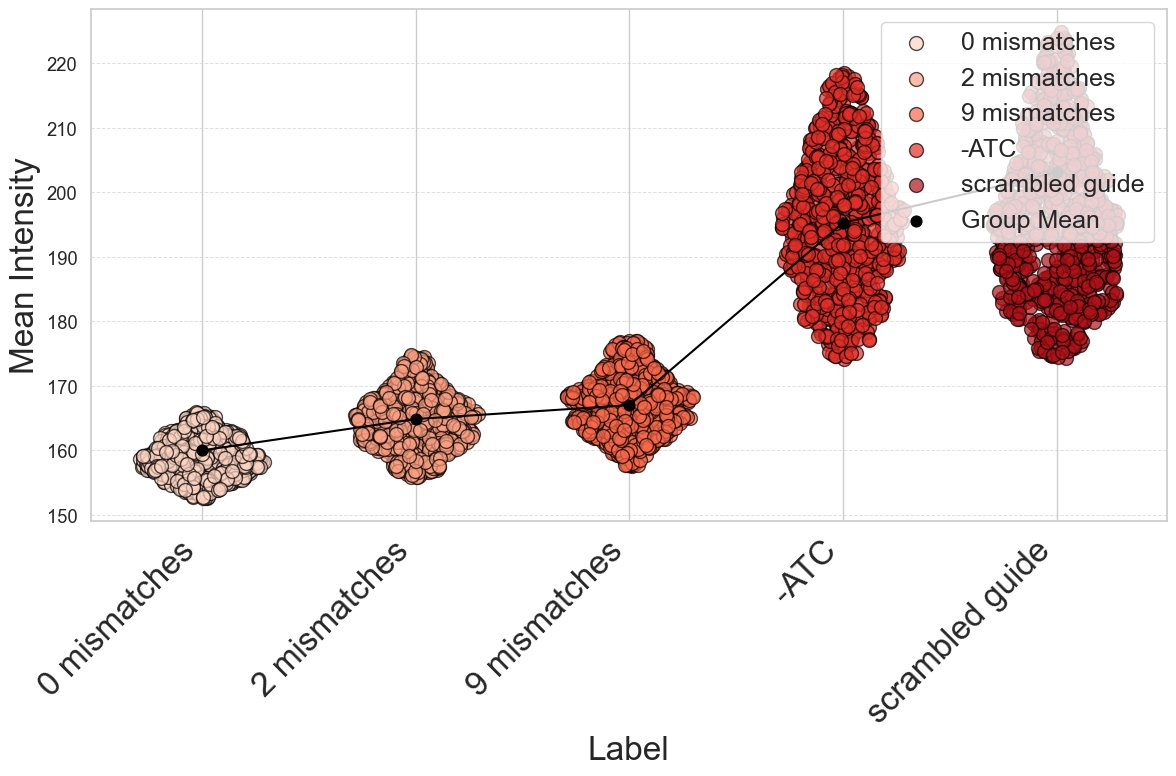

Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Mean_Intensity_vs_Width_KDE_filtered.svg
Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Mean_Intensity_vs_Width_KDE_combined.svg
Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Mean_Intensity_vs_Roundness_KDE.svg


C:\Users\fek64mu\AppData\Local\Temp\ipykernel_12476\2925593122.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Intensity_bin'] = np.digitize(filtered_data["Mean Intensity"], bins)


Saved plot: L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX005_2025_03_21 60xWIA 1.5x CRISPRi mCh\TIF\results\stacked\cyto3_results\Mean_Intensity_vs_Roundness_KDE_combined.svg


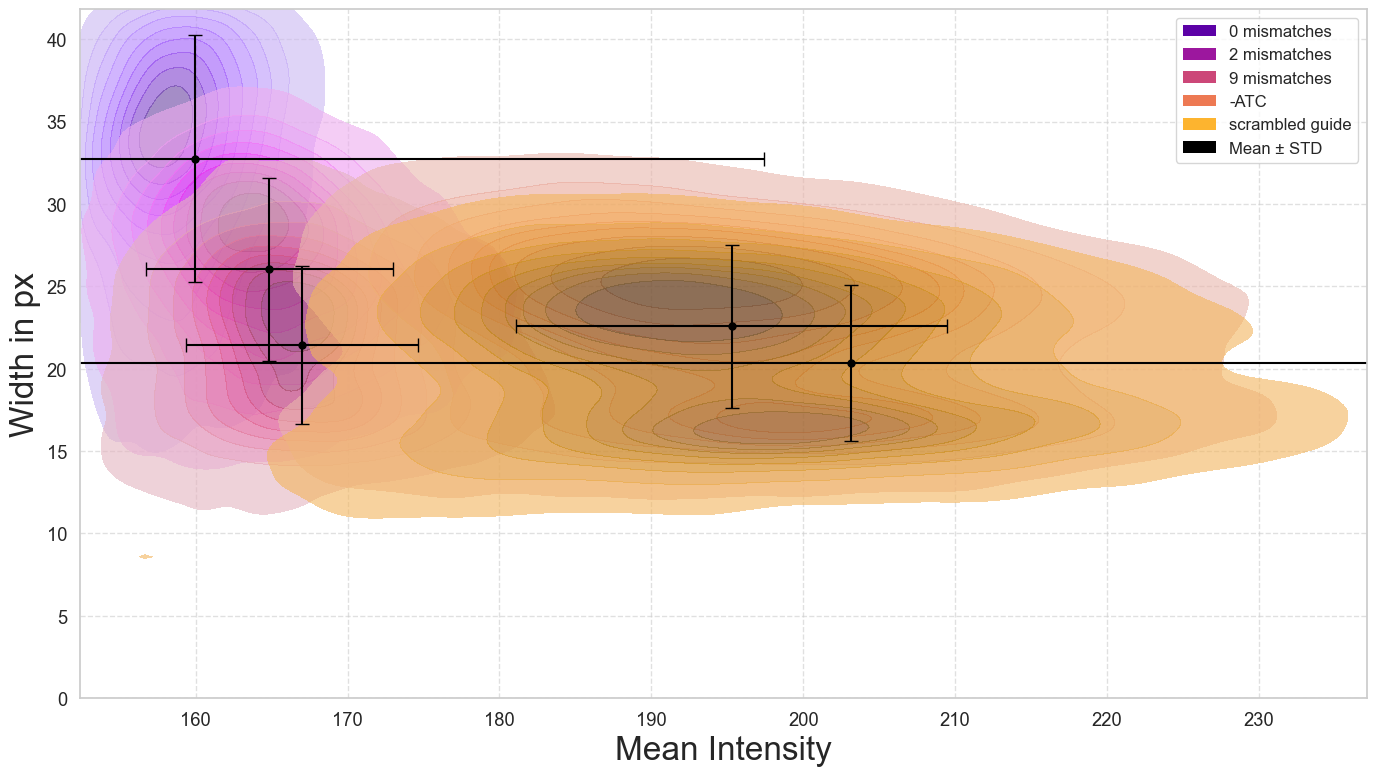

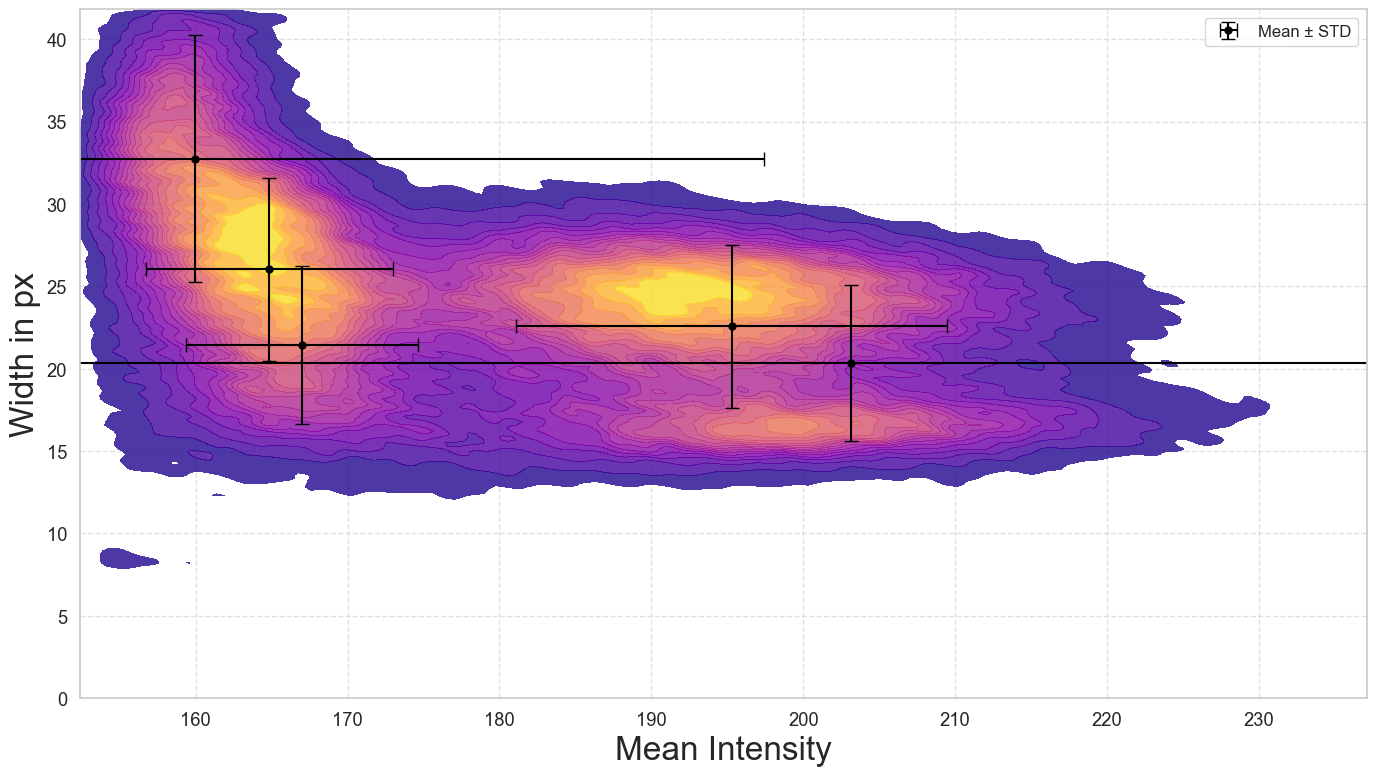

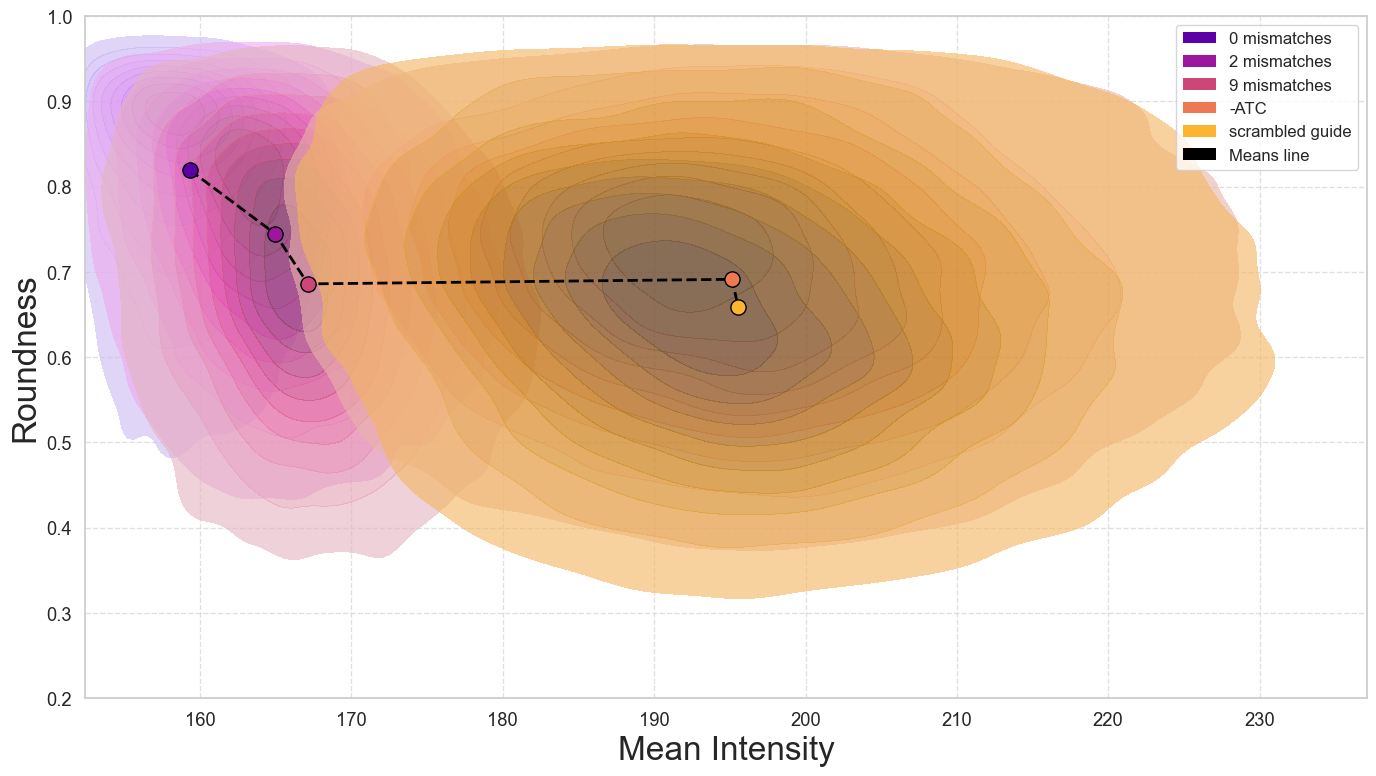

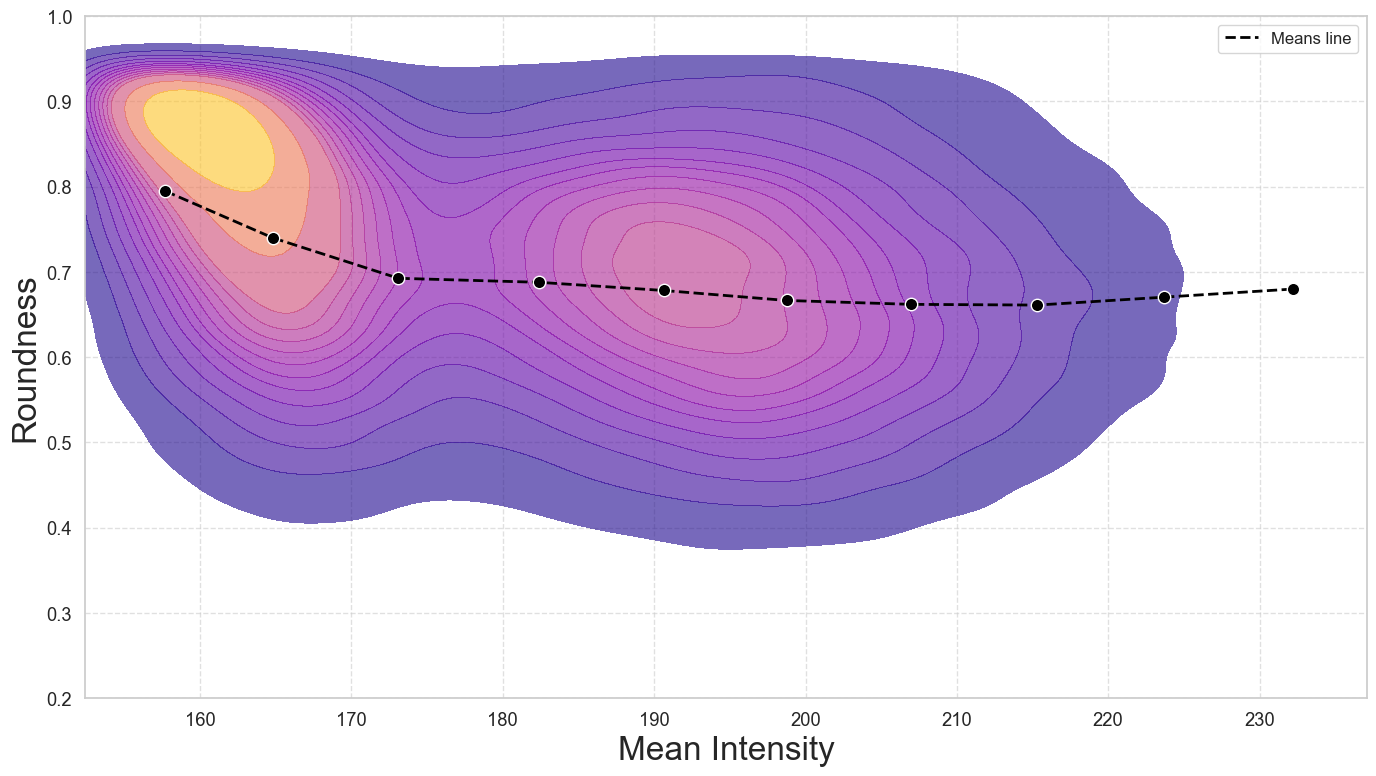

In [16]:
# Generate plots for Area, Roundness, and Mean Intensity
if 'stats' in locals() and not stats.empty:
    plot_comparison(stats, data, "Roundness", output_folder, controls=controls, y_unit="Roundness Factor")
    plot_comparison(stats, data, "Mean Intensity", output_folder, controls=controls, y_unit="Intensity AU")
    
    #Scatter
    plot_violin_scatter(stats, data, "Roundness", output_folder, controls=controls)
    plot_violin_scatter(stats, data, "Mean Intensity", output_folder, controls=controls)
    
    plot_mean_intensity_vs_cell_width(stats, data, output_folder)
    plot_combined_mean_intensity_vs_cell_width(stats, data, output_folder)

    plot_mean_intensity_vs_roundness(stats, data, output_folder)
    plot_combined_mean_intensity_vs_roundness(stats, data, output_folder)
    #plot_mean_intensity_histogram(data, output_folder, controls=controls)
else:
    print("Stats is either not defined or empty. No plots will be generated.")